In [2]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

In [3]:
class ConvAutoencoder:
    @staticmethod
    def build(width,height,depth,filters=(32,64),latentDim=16):
        inputShape = (height,width,depth)
        channelDim = -1
        inputs = Input(shape=inputShape)
        x = inputs
        
        for f in filters:
            x = Conv2D(f,(3,3),strides=2,padding="same")(x)
            x = LeakyReLU(alpha = 0.2)(x)
            x = BatchNormalization(axis = channelDim)(x)
         #creating flatten way   
        volumeSize = K.int_shape(x)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)
        
        encoder = Model(inputs,latent,name="encoder")
        latentInputs = Input(shape=(latentDim,))
        x = Dense(np.prod(volumeSize[1:]))(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2],volumeSize[3]))(x)
        
        for f in filters[::-1]:
            x = Conv2DTranspose(f,(3,3), strides=2,padding = "same")(x)
            x = LeakyReLU(alpha = 0.2)(x)
            x = BatchNormalization(axis = channelDim)(x)
        x = Conv2DTranspose(depth,(3,3),padding="same")(x)
        outputs = Activation("sigmoid")(x)
        
        decoder = Model(latentInputs,outputs, name = "decoder")
        
        autoencoder = Model(inputs,decoder(encoder(inputs)), name="autoencoder")
        
        return (encoder, decoder, autoencoder)

In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random

In [5]:
def build_unsupervised_dataset(data, labels, 
                               validLabel=1, anomalyLabel=3,
                               contam=0.01, seed  = 42):
    validIdxs = np.where(labels == validLabel)[0]
    anomalyIdxs = np.where(labels == anomalyLabel)[0]
    
    random.shuffle(validIdxs)
    random.shuffle(anomalyIdxs)
    
    i = int(len(validIdxs) * contam)
    anomalyIdxs = anomalyIdxs[:i]
    
    validImages = data[validIdxs]
    anomalyImages = data[anomalyIdxs]
    
    images = np.vstack([validImages, anomalyImages])
    
    np.random.seed(seed)
    np.random.shuffle(images)
    
    return images

In [6]:
def visualize_predictions(decoded, gt, samples=10):
    outputs = None
    
    for i in range(0, samples):
        original = (gt[i] * 255).astype("uint8")
        recon = (decoded[i] * 255).astype("uint8")
        
        output = np.hstack([original,recon])
        
        if outputs is None:
            outputs = output
            
        else:
            outputs = np.vstack([outputs,output])
            
    return outputs

In [7]:
from tensorflow.keras.losses import mse
import tensorflow as tf
def step(X,y):
    with tf.GradientTape() as tape:
        pred = autoencoder(X)
        loss = mse(y,pred)
        
    grads = tape.gradient(loss,autoencoder.trainable_variables)
    opt.apply_gradients(zip(grads,autoencoder.trainable_variables))

In [8]:
import sys
import time
EPOCHS = 20
INIT_LR = 1e-3
BS = 32
np.random.seed(3)
((trainX, trainY), (testX, testY)) = mnist.load_data()
images = build_unsupervised_dataset(trainX,trainY, validLabel=1,anomalyLabel=3,contam = 0.01)
images = np.expand_dims(images, axis=-1)
images = images.astype("float32")/255.0
trainX , testX = train_test_split(images, test_size=0.2, random_state=3)
print(trainX.shape)
numUpdates = int(trainX.shape[0]/BS)
(encoder,decoder,autoencoder) = ConvAutoencoder.build(28,28,1)
opt = Adam(lr=INIT_LR, decay = INIT_LR/EPOCHS)

for epoch in range(0,EPOCHS):
    print("Starting epoch {}/{}".format(epoch+1,EPOCHS),end = '')
    sys.stdout.flush()
    epochStart = time.time()
        
    for i in range(0,numUpdates):
        
        start = i*BS
        end = start +BS
        step(trainX[start:end],trainX[start:end])
    
    epochEnd = time.time()
    elapsed = (epochEnd - epochStart)/60.0
    print('time: ',elapsed)

autoencoder.compile(loss='mse',optimizer = opt)

#H = autoencoder.fit(trainX,trainX,validation_data=(testX,testX),epochs=EPOCHS,batch_size = BS)
#autoencoder.save("autoencoder", save_format="h5")
decoded = autoencoder.predict(testX)


(5447, 28, 28, 1)
Starting epoch 1/20time:  0.12528495788574218
Starting epoch 2/20time:  0.11871595780054728
Starting epoch 3/20time:  0.11249612967173259
Starting epoch 4/20time:  0.11328057845433553
Starting epoch 5/20time:  0.1123375137646993
Starting epoch 6/20time:  0.11244090795516967
Starting epoch 7/20time:  0.11251984437306722
Starting epoch 8/20time:  0.11238555113474528
Starting epoch 9/20time:  0.11244738896687825
Starting epoch 10/20time:  0.11294925212860107
Starting epoch 11/20time:  0.11241437594095866
Starting epoch 12/20time:  0.11268552939097086
Starting epoch 13/20time:  0.11264166434605917
Starting epoch 14/20time:  0.11272534132003784
Starting epoch 15/20time:  0.1125389059384664
Starting epoch 16/20time:  0.11250311930974324
Starting epoch 17/20time:  0.11253577470779419
Starting epoch 18/20time:  0.11233548720677694
Starting epoch 19/20time:  0.11253741184870401
Starting epoch 20/20time:  0.11209816137949626


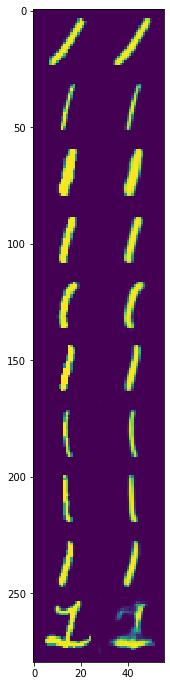

In [9]:
vis = visualize_predictions(decoded,testX)
vis.shape
ss = np.squeeze(vis)
plt.figure(figsize=(12,12))
plt.imshow(ss)
plt.show()

In [10]:
decoded = autoencoder.predict(images)
errors = []

for (image,recon) in zip(images,decoded):
    mse = np.mean((image -recon) **2)
    errors.append(mse)
    
thresh = np.quantile(errors,0.999)
idxs = np.where(np.array(errors) >= thresh)[0]
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(idxs)))


[INFO] mse threshold: 0.03280620399117473
[INFO] 7 outliers found


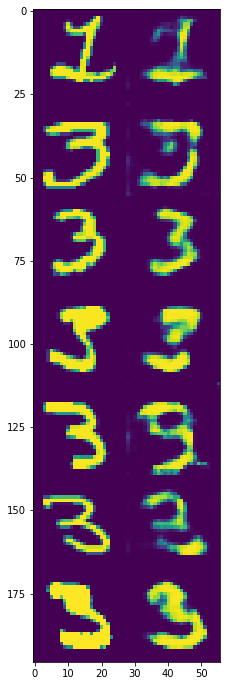

In [11]:
outputs = None
for i in idxs:
    original = (images[i] * 255).astype("uint8")
    recon = (decoded[i] * 255).astype("uint8")
    output = np.hstack([original, recon])

    if outputs is None:
        outputs = output
    else:
        outputs = np.vstack([outputs, output])
s = np.squeeze(outputs)
plt.figure(figsize=(12,12))
plt.imshow(s)
plt.show()

In [14]:
autoencoder.summary()
encoder.summary()
decoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 16)                69392     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         109377    
Total params: 178,769
Trainable params: 178,385
Non-trainable params: 384
_________________________________________________________________
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
______________________________